Mounted at /content/drive
Found 3517 images belonging to 7 classes.
Found 876 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 346s 6s/step - accuracy: 0.4530 - loss: 1.6565 - precision: 0.5049 - recall: 0.3688 - val_accuracy: 0.6427 - val_loss: 0.8832 - val_precision: 0.6706 - val_recall: 0.5811
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.7272 - loss: 0.5687 - precision: 0.7636 - recall: 0.6868 - val_accuracy: 0.6838 - val_loss: 0.7633 - val_precision: 0.7159 - val_recall: 0.6416
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 374s 6s/step - accuracy: 0.7722 - loss: 0.5206 - precision: 0.8010 - recall: 0.7424 - val_accuracy: 0.7785 - val_loss: 0.5543 - val_precision: 0.7933 - val_recall: 0.7534
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 362s 7s/step - accuracy: 0.7996 - loss: 0.4609 - precision: 0.8204 - recall: 0.7758 - val_accuracy: 0.7477 - val_loss: 0.5930 - val_precision: 0.7706 - val_recall: 0.7055
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.7939 - loss: 0.4790 - precision: 0.8081 - recall: 0.7735 - val_accuracy: 0.7968 - val_loss: 0.5068 


Training completed!


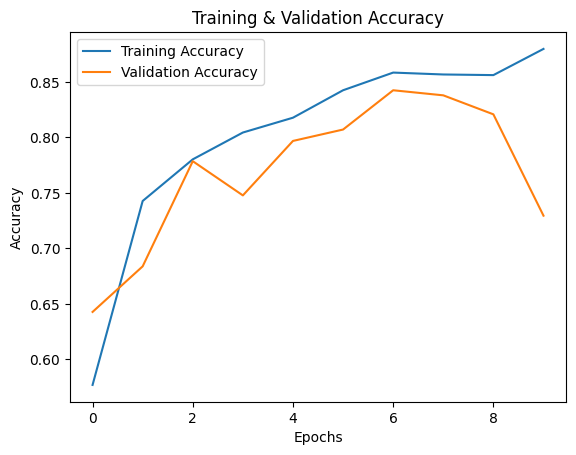

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

drive_base_dir = "/content/drive/MyDrive/Mosquitoes"
zip_file_path = os.path.join(drive_base_dir, "Mosquitoes.zip")
base_dir = "/content/mosquito_dataset"

# Extracting ZIP from Drive
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
!unzip -q "{zip_file_path}" -d "{base_dir}"

base_dir = os.path.join(base_dir, "Mosquitoes")

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.15, horizontal_flip=True, validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(160, 160), batch_size=64, class_mode='categorical', subset='training', shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(160, 160), batch_size=64, class_mode='categorical', subset='validation', shuffle=False
)

# Computing Class Weights
def compute_weights(train_generator):
    class_counts = np.bincount(train_generator.classes)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    return dict(zip(range(len(weights)), weights))

class_weights = compute_weights(train_generator)

# Model Architecture
def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
    for layer in base_model.layers: layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

num_classes = len(train_generator.class_indices)
model = create_model(num_classes)

# Training Model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, class_weight=class_weights)

# Fine-Tuning Model
for layer in model.layers[-10:]: layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=5, validation_data=validation_generator, class_weight=class_weights)

# Saving the Model in Google Colab Files
model_save_path = "/content/mosquito_classifier.h5"
model.save(model_save_path)

print(f"\nTraining completed!")

# Plotting Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


📤 Upload an image (or type 'exit' to quit):


Saving Anopheles_coluzzi_6.jpg to Anopheles_coluzzi_6.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


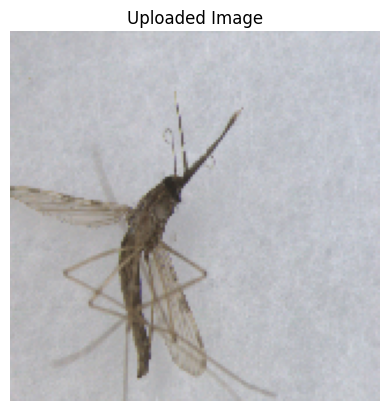


Top 3 Predictions:
Anopheles Coluzzi: 98.85% confidence
Anopheles Arabiensis: 1.10% confidence
Anopheles Albimanus: 0.05% confidence

Do you want to upload another image? (yes/no): yes

📤 Upload an image (or type 'exit' to quit):


Saving Culex_quinquefasciatus_135.jpg to Culex_quinquefasciatus_135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


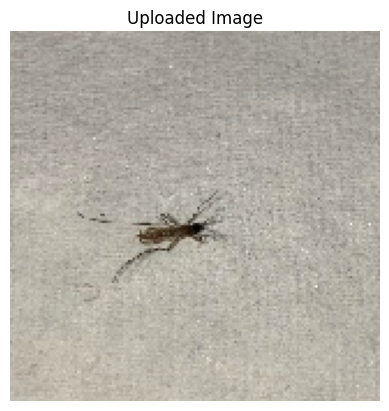


Top 3 Predictions:
Culex Quinquefasciatus: 73.70% confidence
Aedes Aegypti: 20.30% confidence
Anopheles Stephensi: 5.76% confidence

Do you want to upload another image? (yes/no): yes

📤 Upload an image (or type 'exit' to quit):


Saving Aedes_albopictus_22.jpg to Aedes_albopictus_22.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


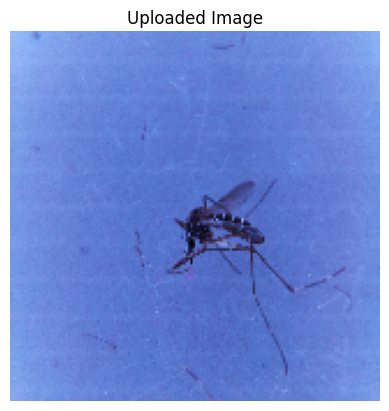


Top 3 Predictions:
Aedes Albopictus: 99.79% confidence
Aedes Aegypti: 0.20% confidence
Anopheles Coluzzi: 0.00% confidence

Do you want to upload another image? (yes/no): yes

📤 Upload an image (or type 'exit' to quit):


Saving Aedes_albimanus_62.jpg to Aedes_albimanus_62.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


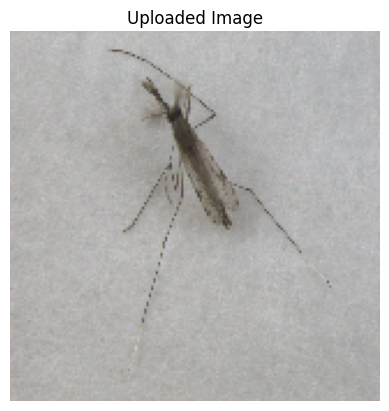


Top 3 Predictions:
Anopheles Albimanus: 100.00% confidence
Anopheles Stephensi: 0.00% confidence
Anopheles Arabiensis: 0.00% confidence

Do you want to upload another image? (yes/no): no
🔚 Exiting image classification. Thank you!


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Loading the trained model
model_path = "/content/mosquito_classifier.h5"
model = tf.keras.models.load_model(model_path)

# Getting class labels from the training data
class_labels = list(train_generator.class_indices.keys())

while True:
    print("\n📤 Upload an image (or type 'exit' to quit):")

    uploaded = files.upload()
    if not uploaded:
        continue

    image_path = list(uploaded.keys())[0]

    # Loading and preprocess image
    img = image.load_img(image_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)[0]

    # Getting top 3 predictions
    top_indices = np.argsort(predictions)[-3:][::-1]
    top_species = [(class_labels[i], predictions[i] * 100) for i in top_indices]

    # Displaying results
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    print("\nTop 3 Predictions:")
    for species, confidence in top_species:
        print(f"{species}: {confidence:.2f}% confidence")

    cont = input("\nDo you want to upload another image? (yes/no): ").strip().lower()
    if cont != 'yes':
        print("🔚 Exiting image classification. Thank you!")
        break